# **Práctica 2: Sensado y análisis de video**

### Ciencia de Datos para Sensores Inteligentes/Tópicos Selectos en Sistemas Interactivos

*Estudiante: Cielo Aholiva Higuera Gutiérrez*

El proposito de este notebook es recolectar videos sobre la validación automática de la evaluación Fugl-Meyer para la Extremidad Superior (FMA-UE). Esta evaluación es fundamental para medir el deterioro sensoriomotor en personas que han sufrido un accidente cerebrovascular.

**Dataset**

El dataset se generó a partir de la evaluación automática de Fugl-Meyer para la Extremidad Superior (FMA-UE), un índice utilizado para medir el deterioro sensoriomotor en personas que han sufrido un accidente cerebrovascular. Para la evaluación, se realizaron los siguientes movimientos:

* (1) Flexión de hombro.
* (2) Abducción de Hombro.
* (3) Rotación Externa de Hombro.
* (4) Extensión de Codo.
* (5) Extensión de Dedos.

Cada movimiento fue clasificado según los siguientes criterios:

* (1) Complete: El movimiento se realizó correctamente, sin dificultades.
* (2) Incomplete: El movimiento se realizó de manera parcial y presentó dificultades motoras.
* (3) Null: No se logró realizar el movimiento

El formato para los nombres de los archivos es el siguiente: PERSONA-METODO_CRITERO.

* PERSONA: Nombre del participante para identificar los archivos individuales.
* MOVIMIENTO: Número que representa el tipo de movimiento realizado.
* CRITERIO: Clasificación obtenida en la evaluación (Complete, Incomplete o Null).

***Librerias***

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install mediapipe opencv-python --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 12.3 MB/s eta 0:00:00


In [ ]:
# system libraries
import os
import sys
import re

# data
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

# video
import mediapipe as mp
import cv2
from IPython.display import Video
from google.colab.patches import cv2_imshow

# machine learning models
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

In [63]:
video_path = "/content/drive/MyDrive/CDSI/Notebooks/Practica 2/Videos"

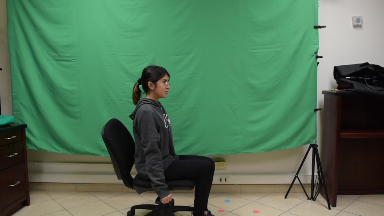

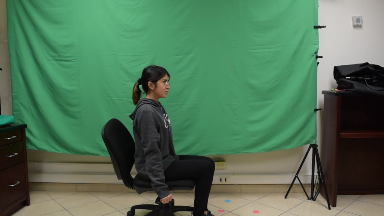

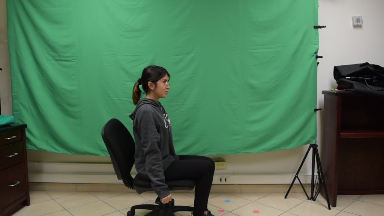

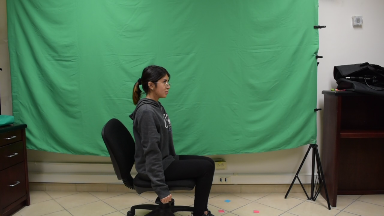

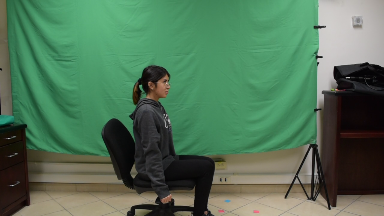

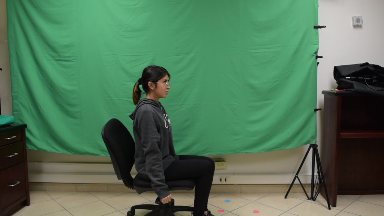

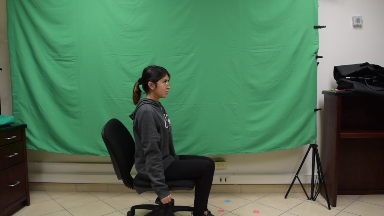

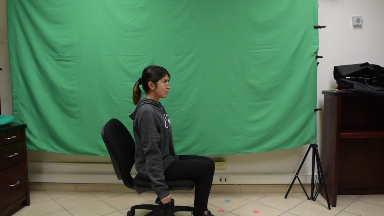

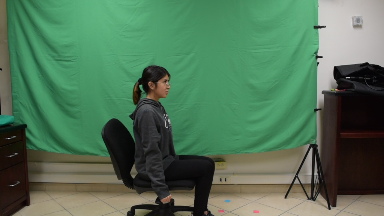

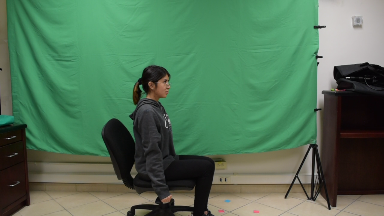

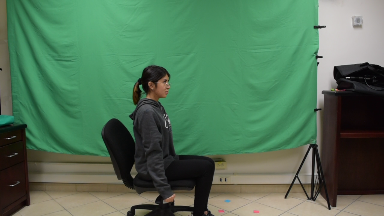

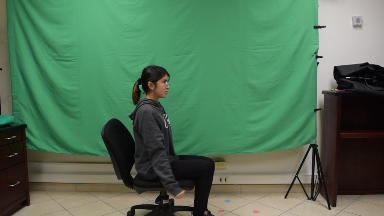

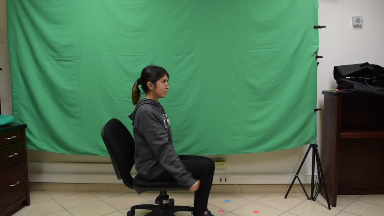

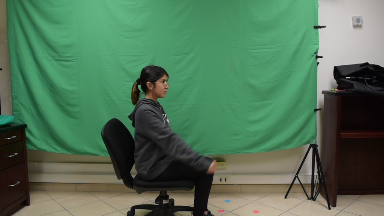

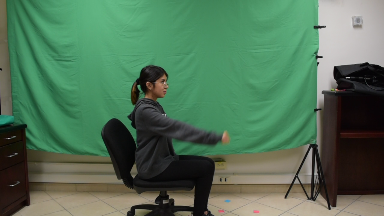

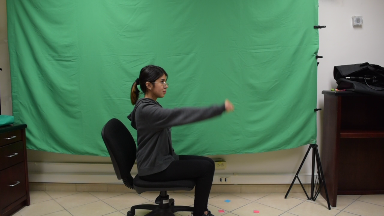

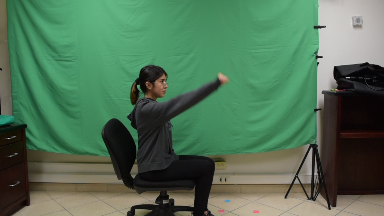

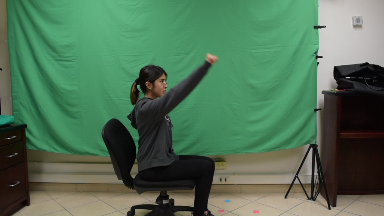

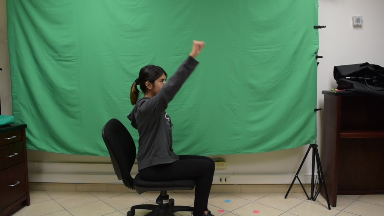

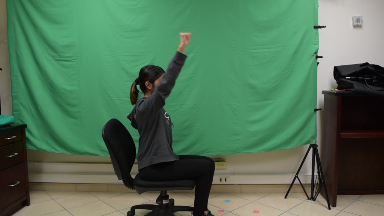

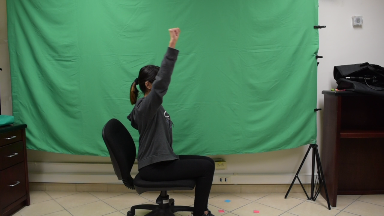

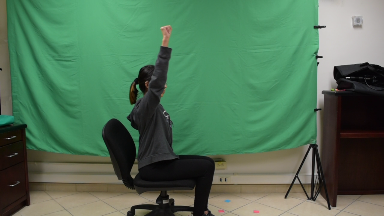

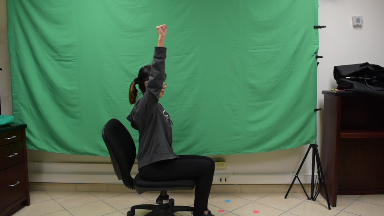

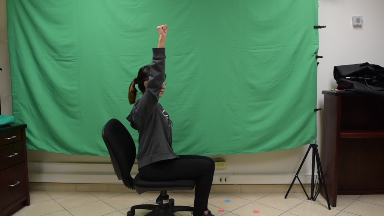

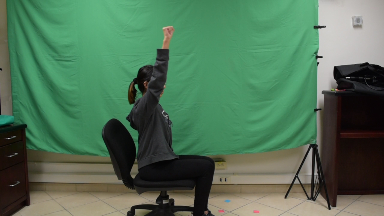

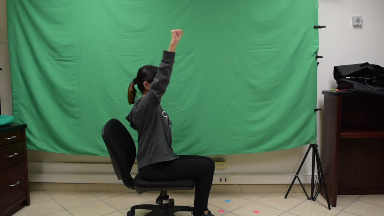

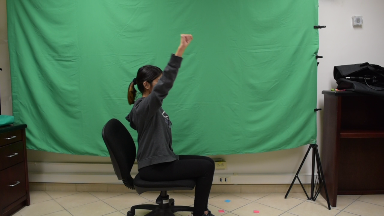

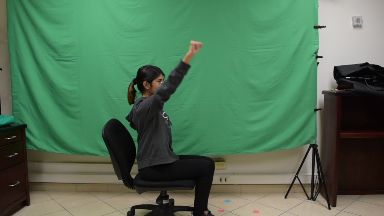

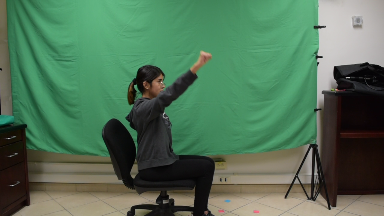

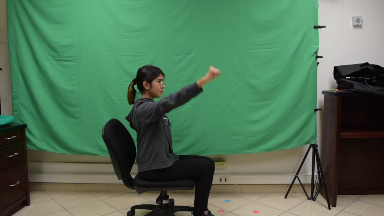

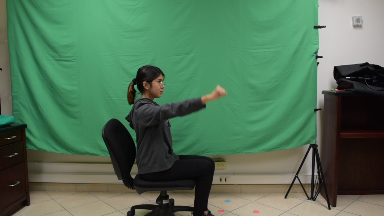

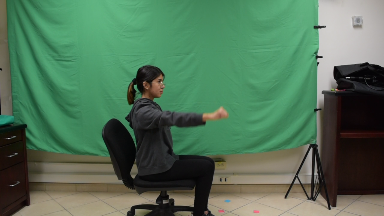

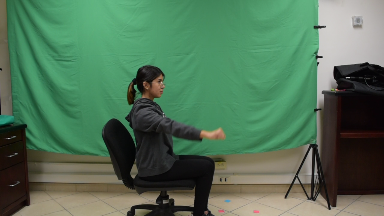

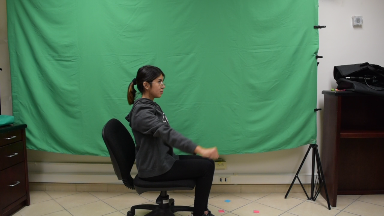

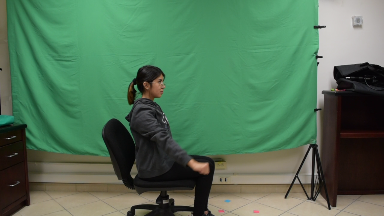

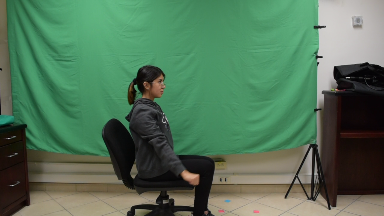

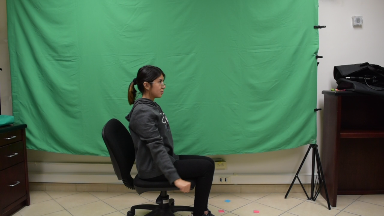

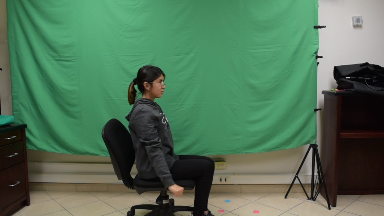

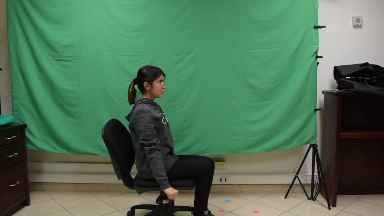

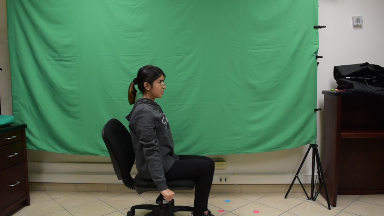

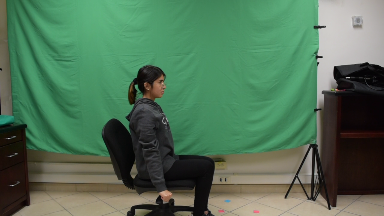

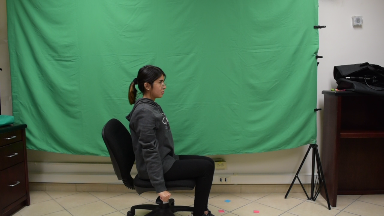

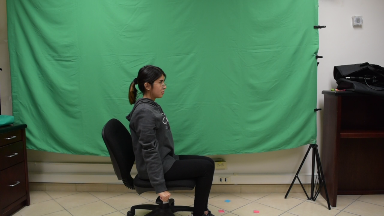

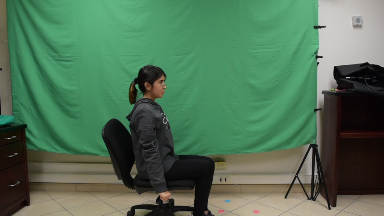

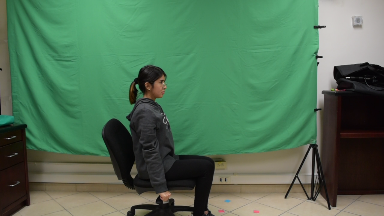

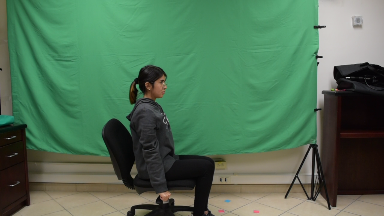

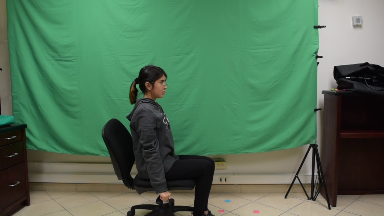

Total de fotogramas leídos: 237


In [62]:
video_ejemplo = "/content/drive/MyDrive/CDSI/Notebooks/Practica 2/Videos/Cielo/Cielo_01-Complete.MOV"
cap = cv2.VideoCapture(video_ejemplo)

frame_count = 0
resize_factor = 0.3

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    frame_count += 1
    if frame_count % 5 == 0:  # Mostrar cada 5 fotogramas
        frame_resized = cv2.resize(frame, (0, 0), fx=resize_factor, fy=resize_factor)
        cv2_imshow(frame_resized)

cap.release()
print(f"Total de fotogramas leídos: {frame_count}")

## **Extracción de características**

En esta sección se extraen las características de los videos grabados.

Landmarks del primer fotograma:
x: 0.43934518098831177, y: 0.4035751223564148, z: 0.003787789959460497
x: 0.434626042842865, y: 0.38432320952415466, z: 0.017436988651752472
x: 0.43404167890548706, y: 0.3838065564632416, z: 0.017436210066080093
x: 0.433311402797699, y: 0.3830941617488861, z: 0.017466340214014053
x: 0.4324926733970642, y: 0.38495397567749023, z: -0.018765415996313095
x: 0.4304279386997223, y: 0.38497933745384216, z: -0.018762709572911263
x: 0.42786675691604614, y: 0.3849971890449524, z: -0.018887745216488838
x: 0.41536611318588257, y: 0.38876640796661377, z: 0.06728076189756393
x: 0.4110201895236969, y: 0.39107412099838257, z: -0.0925569012761116
x: 0.435230553150177, y: 0.4243622124195099, z: 0.02377155050635338
x: 0.4329189360141754, y: 0.42398741841316223, z: -0.022046739235520363
x: 0.38567689061164856, y: 0.5080021619796753, z: 0.15880662202835083
x: 0.39154356718063354, y: 0.5135819911956787, z: -0.18815837800502777
x: 0.4099666476249695, y: 0.664729654788971, z: 0

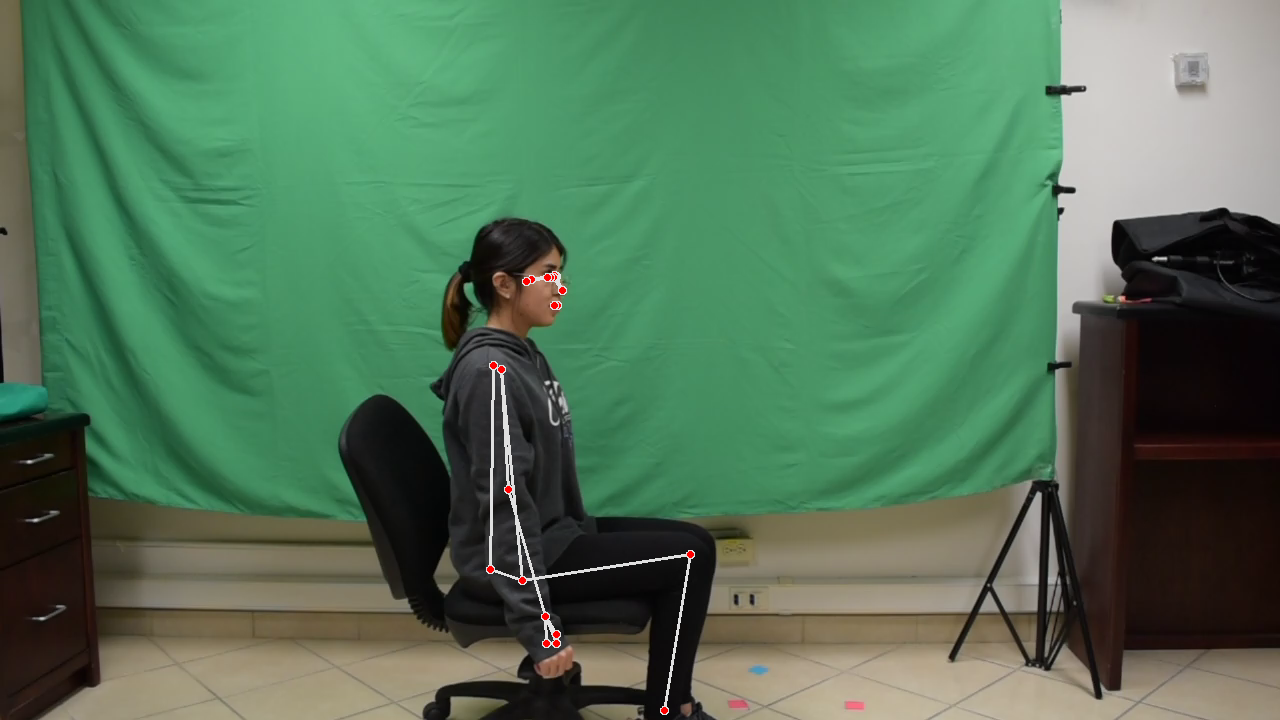

In [ ]:
# Inicializar MediaPipe Pose
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5)

# Función para extraer los landmarks del cuerpo en un video
def obtener_landmarks(video_path):
    cap = cv2.VideoCapture(video_path)

    # Leer solo el primer fotograma del video
    ret, frame = cap.read()
    if not ret:
        print("No se pudo leer el video.")
        return

    # Convertir el fotograma a RGB
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # Detectar los landmarks
    results = pose.process(frame_rgb)

    if results.pose_landmarks:
        # Extraer los landmarks y mostrarlos
        print("Landmarks del primer fotograma:")
        for landmark in results.pose_landmarks.landmark:
            print(f"x: {landmark.x}, y: {landmark.y}, z: {landmark.z}")

        # Dibujar los landmarks en el fotograma
        mp.solutions.drawing_utils.draw_landmarks(frame, results.pose_landmarks, mp_pose.POSE_CONNECTIONS)

    # Mostrar solo el primer fotograma con los landmarks
    cv2_imshow(frame)

    cap.release()

# Ruta del video
video_path = "/content/drive/MyDrive/CDSI/Notebooks/Practica 2/Videos/Cielo/Cielo_01-Complete.MOV"
obtener_landmarks(video_path)

En esta sección se van a extraer los landmarks del cuerpo de videos de movimientos terapéuticos usando MediaPipe y los guarda en archivos CSV, organizados por frames. Cada CSV contiene coordenadas (x, y, z) visibilidad de los 33 puntos del cuerpo por cada frame de video.

In [71]:
# Rutas
VIDEO_DIR = "/content/drive/MyDrive/CDSI/Notebooks/Practica 2/Videos"
OUTPUT_DIR = "/content/drive/MyDrive/CDSI/Notebooks/Practica 2/Landmarks_CSV"

# Inicializar MediaPipe Pose
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5)

Path(OUTPUT_DIR).mkdir(parents=True, exist_ok=True)

def process_video(video_path, output_csv):
    cap = cv2.VideoCapture(video_path)
    data = []

    frame_id = 0
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # Convertir imagen a RGB
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = pose.process(frame_rgb)

        if results.pose_landmarks:
            landmarks = []
            for lm in results.pose_landmarks.landmark:
                landmarks.extend([lm.x, lm.y, lm.z, lm.visibility])
            data.append([frame_id] + landmarks)

        frame_id += 1

    cap.release()

    # Guardar en CSV
    if data:
        columns = ["frame"] + [f"{name}_{axis}" for name in range(33) for axis in ["x", "y", "z", "visibility"]]
        df = pd.DataFrame(data, columns=columns)
        df.to_csv(output_csv, index=False)
        print(f"Guardado: {output_csv}")
    else:
        print(f"Advertencia: No se detectaron landmarks en {video_path}")

# Procesar todos los videos en la carpeta
for student_folder in os.listdir(VIDEO_DIR):
    student_path = os.path.join(VIDEO_DIR, student_folder)
    if os.path.isdir(student_path):
        for video_file in os.listdir(student_path):
            if video_file.endswith(".MOV"):
                video_path = os.path.join(student_path, video_file)
                csv_name = video_file.replace(".MOV", ".csv")
                output_csv = os.path.join(OUTPUT_DIR, csv_name)
                process_video(video_path, output_csv)

print("Procesamiento completado.")

KeyboardInterrupt: 

En esta sección se concatenan todos los archivos CSV generados anteriormente en un único dataset. Se crea un dataset estructurado a partir de los landmarks extraídos de los videos, incluyendo la etiqueta del movimiento para el entrenamiento del modelo.

In [ ]:
# Directorio donde están los CSV generados
CSV_DIR = "/content/drive/MyDrive/CDSI/Notebooks/Practica 2/Landmarks_CSV"
OUTPUT_CSV = "/content/drive/MyDrive/CDSI/Notebooks/Practica 2/Dataset.csv"

all_data = []
for file in os.listdir(CSV_DIR):
    if file.endswith(".csv"):
        label = "Complete" if "Complete" in file else "Incomplete" if "Incomplete" in file else "Null"
        df = pd.read_csv(os.path.join(CSV_DIR, file))
        df["label"] = label
        df["video"] = file
        all_data.append(df)

# Concatenar todos los CSVs en un DataFrame único
df_all = pd.concat(all_data, ignore_index=True)
df_all.to_csv(OUTPUT_CSV, index=False)
print(f"Dataset guardado en {OUTPUT_CSV}")

Dataset guardado en /content/drive/MyDrive/CDSI/Notebooks/Practica 2/Dataset.csv


**Normalización de datos**

In [ ]:
def normalizar_landmarks(df):
    # Tomar referencia de la distancia entre hombros
    hombro_izq = df[["11_x", "11_y", "11_z"]].values
    hombro_der = df[["12_x", "12_y", "12_z"]].values
    escala = np.linalg.norm(hombro_izq - hombro_der, axis=1, keepdims=True)  # Distancia hombros

    # Normalizar todos los puntos con respecto a esa escala
    for col in df.columns:
        if col.endswith(("_x", "_y", "_z")):
            df[col] = df[col] / escala  # Escalamiento
    return df

In [ ]:
def compute_distance(row, p1, p2):
    """ Calcula la distancia euclidiana entre dos landmarks. """
    x1, y1 = row[f"{p1}_x"], row[f"{p1}_y"]
    x2, y2 = row[f"{p2}_x"], row[f"{p2}_y"]
    return np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)

df_all["shoulder_distance"] = df_all.apply(lambda row: compute_distance(row, 11, 12), axis=1)

In [ ]:
landmark = pd.read_csv("/content/drive/MyDrive/CDSI/Notebooks/Practica 2/Dataset.csv")
landmark

frame       0_x       0_y       0_z  0_visibility       1_x       1_y  \
0          0  0.435656  0.352902 -0.029213      0.999837  0.428130  0.334300   
1          1  0.434701  0.353041  0.005097      0.999826  0.426886  0.334245   
2          2  0.434251  0.352938  0.008600      0.999807  0.426076  0.333818   
3          3  0.433778  0.353271  0.011825      0.999781  0.425706  0.333996   
4          4  0.433644  0.353317  0.010185      0.999754  0.425494  0.334023   
...      ...       ...       ...       ...           ...       ...       ...   
39709    190  0.422781  0.377825  0.110165      0.999845  0.418367  0.357705   
39710    191  0.422785  0.377830  0.111032      0.999845  0.418371  0.357718   
39711    192  0.422757  0.377852  0.106916      0.999841  0.418347  0.357742   
39712    193  0.422727  0.377870  0.105432      0.999836  0.418314  0.357768   
39713    194  0.422720  0.377885  0.105572      0.999833  0.418307  0.357789   

            1_z  1_visibility       2_x  ...      31_x      31_y      31_z  \
0     -0.009084      0.999852  0.427129  ...  0.443564  0.944883  0.282221   
1      0.026272      0.999845  0.425791  ...  0.443480  0.945046  0.228732   
2      0.030210      0.999829  0.424901  ...  0.429781  0.938459  0.249218   
3      0.032191      0.999807  0.424556  ...  0.405140  0.926440  0.256437   
4      0.031268      0.999782  0.424330  ...  0.412918  0.927238  0.260444   
...         ...           ...       ...  ...       ...       ...       ...   
39709  0.116224      0.999898  0.417074  ...  0.563404  0.918537  0.039863   
39710  0.116966      0.999897  0.417079  ...  0.563415  0.919248  0.042502   
39711  0.112467      0.999895  0.417058  ...  0.563416  0.919400  0.063775   
39712  0.110305      0.999891  0.417026  ...  0.547362  0.912887  0.108159   
39713  0.110534      0.999888  0.417019  ...  0.562854  0.915957  0.087808   

       31_visibility      32_x      32_y      32_z  32_visibility       label  \
0           0.086761  0.545512  1.046781  0.018698       0.833412  Incomplete   
1           0.098045  0.535948  1.042638 -0.019995       0.835041  Incomplete   
2           0.104435  0.537287  1.039269 -0.008741       0.836774  Incomplete   
3           0.109393  0.537455  1.035084 -0.003382       0.836927  Incomplete   
4           0.111603  0.538177  1.032999  0.006706       0.834881  Incomplete   
...              ...       ...       ...       ...            ...         ...   
39709       0.554210  0.595327  1.052449 -0.208252       0.949670        Null   
39710       0.552560  0.595467  1.052528 -0.207420       0.949233        Null   
39711       0.549526  0.597030  1.053467 -0.192884       0.948915        Null   
39712       0.539901  0.601048  1.060159 -0.177410       0.948133        Null   
39713       0.535931  0.603745  1.060330 -0.175153       0.948015        Null   

                        video  
0      Luis_01-Incomplete.csv  
1      Luis_01-Incomplete.csv  
2      Luis_01-Incomplete.csv  
3      Luis_01-Incomplete.csv  
4      Luis_01-Incomplete.csv  
...                       ...  
39709       Jorge_04-Null.csv  
39710       Jorge_04-Null.csv  
39711       Jorge_04-Null.csv  
39712       Jorge_04-Null.csv  
39713       Jorge_04-Null.csv  

[39714 rows x 135 columns]

<ipython-input-66-d4e219558547>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x=label_frequencies.index, y=label_frequencies.values, palette=purple_palette)
<ipython-input-66-d4e219558547>:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  barplot.set_xticklabels(barplot.get_xticklabels(), rotation=45, horizontalalignment='right')


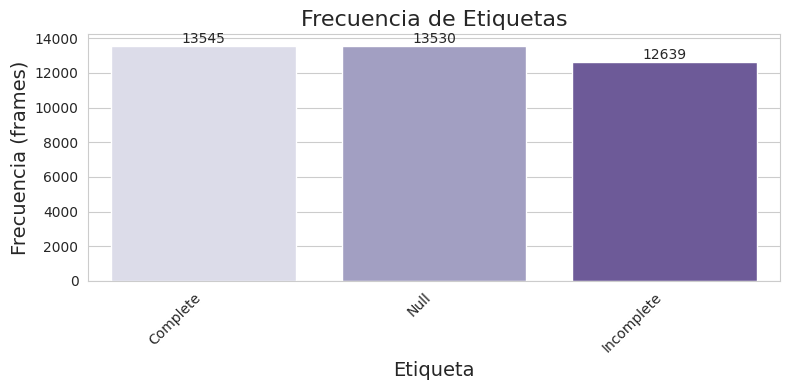

In [66]:
# Calcular la frecuencia de las etiquetas
label_frequencies = df_all['label'].value_counts()

sns.set_style("whitegrid")
purple_palette = sns.color_palette("Purples", len(label_frequencies))

# Crear el gráfico de barras
plt.figure(figsize=(8, 4))
barplot = sns.barplot(x=label_frequencies.index, y=label_frequencies.values, palette=purple_palette)
plt.title('Frecuencia de Etiquetas', fontsize=16)
plt.xlabel('Etiqueta', fontsize=14)
plt.ylabel('Frecuencia (frames)', fontsize=14)

barplot.set_xticklabels(barplot.get_xticklabels(), rotation=45, horizontalalignment='right')

for index, value in enumerate(label_frequencies):
    barplot.text(index, value, str(value), ha='center', va='bottom')

plt.tight_layout()
plt.show()

### **Construcción y validación de modelos**

***Modelo Random Forest***

In [ ]:
# Seleccionar características
features = df_all.drop(columns=["frame", "label", "video"])
labels = df_all["label"]

# Dividir en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

# Entrenar modelo
clf = RandomForestClassifier(n_estimators=2, random_state=42)
clf.fit(X_train, y_train)

# Evaluación
y_pred = clf.predict(X_test)
print(f"Precisión del modelo: {accuracy_score(y_test, y_pred):.2f}")

Precisión del modelo: 0.97


In [ ]:
# Calcular precisión del modelo
accuracy = accuracy_score(y_test, y_pred)
print(f"Precisión del modelo: {accuracy * 100:.2f}%")

# Generar reporte con más métricas
print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred))

Precisión del modelo: 97.34%

Reporte de clasificación:
              precision    recall  f1-score   support

    Complete       0.95      0.99      0.97      2692
  Incomplete       0.97      0.96      0.97      2569
        Null       1.00      0.97      0.98      2682

    accuracy                           0.97      7943
   macro avg       0.97      0.97      0.97      7943
weighted avg       0.97      0.97      0.97      7943



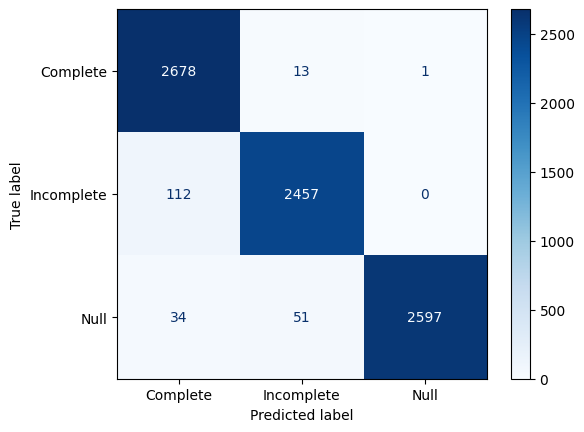

In [ ]:
# Generar la matriz de confusión
cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)

# Mostrar la matriz de confusión
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot(cmap="Blues")

In [ ]:
results = pd.DataFrame({
    "Real": y_test,
    "Predicción": y_pred
})

# Filtrar los casos en los que el modelo se equivocó
wrong_predictions = results[results["Real"] != results["Predicción"]]

# Mostrar los primeros casos donde el modelo se equivocó
print("Casos en los que el modelo se equivocó:")
print(wrong_predictions.head())

Casos en los que el modelo se equivocó:
             Real  Predicción
31906        Null  Incomplete
12978        Null    Complete
35061        Null    Complete
21121        Null  Incomplete
16898  Incomplete    Complete


In [ ]:
wrong_predictions["Video"] = df_all.loc[wrong_predictions.index, "video"]
wrong_predictions["Frame"] = df_all.loc[wrong_predictions.index, "frame"]
print(wrong_predictions[["Video", "Frame", "Real", "Predicción"]])

                          Video  Frame        Real  Predicción
31906         Cielo_03-Null.csv     31        Null  Incomplete
12978        Miguel_03-Null.csv      0        Null    Complete
35061         Nacho_05-Null.csv     99        Null    Complete
21121           Jesus_01-01.csv    136        Null  Incomplete
16898  Ariana_05-Incomplete.csv    236  Incomplete    Complete
...                         ...    ...         ...         ...
775            Luis_01-Null.csv     25        Null  Incomplete
6754          David_05-Null.csv      4        Null  Incomplete
12104        Miguel_05-Null.csv      8        Null    Complete
26196   Mario_02-Incomplete.csv      0  Incomplete    Complete
31917         Cielo_03-Null.csv     42        Null  Incomplete

[211 rows x 4 columns]


<ipython-input-11-d9f4bcf899e0>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wrong_predictions["Video"] = df_all.loc[wrong_predictions.index, "video"]
<ipython-input-11-d9f4bcf899e0>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wrong_predictions["Frame"] = df_all.loc[wrong_predictions.index, "frame"]


Validación del modelo con un video del dataset

In [ ]:
# Cargar modelo guardado
def load_model(model_path):
    if not os.path.exists(model_path):
        print(f"Error: No se encontró el modelo en {model_path}")
        return None
    return joblib.load(model_path)

if __name__ == "__main__":
    model_path = 'video_recognition_01.pkl'

    if not os.path.exists(model_path):
        print("Entrenando el modelo...")
        folder_path = '/content/drive/MyDrive/CDSI/Notebooks/Practica 2/Videos'
        videos = load_video_files(folder_path)
        data, labels = extract_landmarks(videos)
        model = build_model(data, labels)
    else:
        print("Cargando modelo existente...")
        model = load_model(model_path)

    # Evaluar un video nuevo
    video_path = '/content/drive/MyDrive/CDSI/Notebooks/Practica 2/Videos/Cielo/Cielo_02-Complete.MOV'
    validate_model(model, video_path)

Cargando modelo existente...
Predicción para el video /content/drive/MyDrive/CDSI/Notebooks/Practica 2/Videos/Cielo/Cielo_02-Complete.MOV: 0
El video fue clasificado como: Complete


Validación del modelo con un video externo

In [ ]:
# Cargar modelo guardado
def load_model(model_path):
    if not os.path.exists(model_path):
        print(f"Error: No se encontró el modelo en {model_path}")
        return None
    return joblib.load(model_path)

if __name__ == "__main__":
    model_path = 'video_recognition_01.pkl'

    if not os.path.exists(model_path):
        print("Entrenando el modelo...")
        folder_path = '/content/drive/MyDrive/CDSI/Notebooks/Practica 2/Videos'
        videos = load_video_files(folder_path)
        data, labels = extract_landmarks(videos)
        model = build_model(data, labels)
    else:
        print("Cargando modelo existente...")
        model = load_model(model_path)

    # Evaluar un video nuevo
    video_path = '/content/drive/MyDrive/CDSI/Notebooks/Practica 2/persona_01-Complete.mov'
    validate_model(model, video_path)

Cargando modelo existente...
Predicción para el video /content/drive/MyDrive/CDSI/Notebooks/Practica 2/persona_01-Complete.mov: 0
El video fue clasificado como: Complete


El modelo de Random Forest alcanzó una precisión del 97.34%. El modelo tiene una alta capacidad para predecir correctamente las tres clases ("Complete", "Incomplete", "Null"), especialmente para la clase "Null", donde tiene una precisión perfecta (1.00). Los errores ocurren en algunos casos de la clase "Null", donde el modelo tiende a confundirla con otras categorías, lo cual es un problema común cuando hay muchas clases o cuando las características entre las clases no son claramente diferenciables. Algunos casos donde el modelo se equivocó son:
* El modelo predijo "Incomplete" o "Complete" cuando el valor real era "Null" (por ejemplo, en los casos con índices 31906, 12978, 35061).
* En otros casos, el modelo predijo incorrectamente "Complete" cuando era "Incomplete".

Para la predicción y validación del modelo, se utilizó un video del conjunto de datos, el cual permitió al modelo clasificar correctamente el movimiento realizado. Sin embargo, cuando se cargó un video nuevo grabado en un entorno diferente, con variaciones en la iluminación y condiciones de grabación, el modelo clasificó incorrectamente el movimiento como "Completo", cuando en realidad era "Incompleto". Este comportamiento sugiere que el modelo tiene dificultades para generalizar en condiciones no controladas y fuera del entorno específico en el que fue entrenado.

***Modelo KNN***

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/CDSI/Notebooks/Practica 2/Dataset.csv")

# Seleccionar características (excluyendo "frame" y "video")
features = df.drop(columns=["frame", "video", "label"])
labels = df["label"]

# Convertir etiquetas a valores numéricos
encoder = LabelEncoder()
y = encoder.fit_transform(labels)

# Separar datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(features, y, test_size=0.2, random_state=42)

# Modelo KNN
model = KNeighborsClassifier(n_neighbors=3)
model.fit(X_train, y_train)

# Predicciones
y_pred = model.predict(X_test)

# Validación cruzada con KNN
knn_scores = cross_val_score(model, X_train, y_train, cv=5)
print(f"Precisión promedio KNN (5-fold CV): {np.mean(knn_scores):.2f}")

Precisión promedio KNN (5-fold CV): 0.99


In [ ]:
# Calcular precisión del modelo
accuracy = accuracy_score(y_test, y_pred)
print(f"Precisión del modelo: {accuracy * 100:.2f}%")

# Generar reporte con más métricas
print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred, target_names=encoder.classes_))

Precisión del modelo: 99.40%

Reporte de clasificación:
              precision    recall  f1-score   support

    Complete       0.99      0.99      0.99      2692
  Incomplete       0.99      0.99      0.99      2569
        Null       1.00      1.00      1.00      2682

    accuracy                           0.99      7943
   macro avg       0.99      0.99      0.99      7943
weighted avg       0.99      0.99      0.99      7943



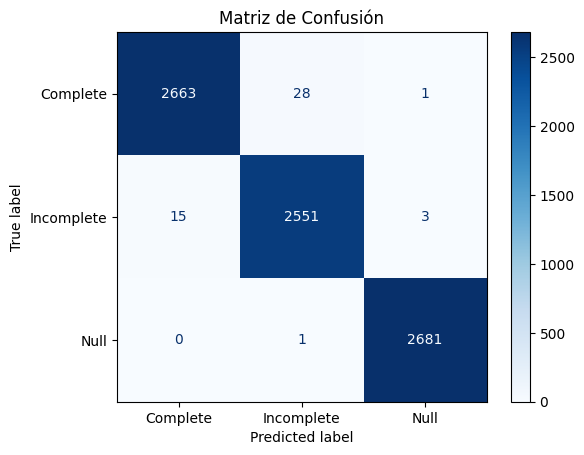

In [ ]:
# Generar la matriz de confusión
cm = confusion_matrix(y_test, y_pred)

# Mostrar la matriz de confusión con nombres de clases
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=encoder.classes_)
disp.plot(cmap="Blues")
plt.title("Matriz de Confusión")
plt.show()

In [ ]:
# Diccionario para mapear números a etiquetas de clase
label_mapping = {0: "Complete", 1: "Incomplete", 2: "Null"}

results = pd.DataFrame({
    "Real": pd.Series(y_test).map(label_mapping),
    "Predicción": pd.Series(y_pred).map(label_mapping)
})

# Filtrar los errores
wrong_predictions = results[results["Real"] != results["Predicción"]]

# Mostrar los primeros casos incorrectos
print("Casos en los que el modelo se equivocó:")
print(wrong_predictions.head())

Casos en los que el modelo se equivocó:
           Real  Predicción
10     Complete  Incomplete
30     Complete  Incomplete
385  Incomplete    Complete
446    Complete  Incomplete
500    Complete  Incomplete


In [ ]:
wrong_predictions = wrong_predictions.reset_index(drop=True)
df_all_reset = df_all.reset_index(drop=True)

# Agregar las columnas de video y frame
wrong_predictions["Video"] = df_all_reset.loc[wrong_predictions.index, "video"]
wrong_predictions["Frame"] = df_all_reset.loc[wrong_predictions.index, "frame"]

# Mostrar los resultados
print(wrong_predictions[["Video", "Frame", "Real", "Predicción"]])

                     Video  Frame        Real  Predicción
0   Luis_01-Incomplete.csv      0    Complete  Incomplete
1   Luis_01-Incomplete.csv      1    Complete  Incomplete
2   Luis_01-Incomplete.csv      2  Incomplete    Complete
3   Luis_01-Incomplete.csv      3    Complete  Incomplete
4   Luis_01-Incomplete.csv      4    Complete  Incomplete
5   Luis_01-Incomplete.csv      5    Complete  Incomplete
6   Luis_01-Incomplete.csv      6    Complete  Incomplete
7   Luis_01-Incomplete.csv      7  Incomplete    Complete
8   Luis_01-Incomplete.csv      8    Complete  Incomplete
9   Luis_01-Incomplete.csv      9    Complete        Null
10  Luis_01-Incomplete.csv     10    Complete  Incomplete
11  Luis_01-Incomplete.csv     11    Complete  Incomplete
12  Luis_01-Incomplete.csv     12    Complete  Incomplete
13  Luis_01-Incomplete.csv     13    Complete  Incomplete
14  Luis_01-Incomplete.csv     14    Complete  Incomplete
15  Luis_01-Incomplete.csv     15  Incomplete    Complete
16  Luis_01-In

In [ ]:
import joblib
joblib.dump(model, 'knn_model.pkl')

['knn_model.pkl']

Validación del modelo con un video del dataset

In [ ]:
# Cargar modelo entrenado
def load_trained_model(model_path):
    return joblib.load(model_path)

def extract_features_from_video(video_path):
    mp_pose = mp.solutions.pose
    pose = mp_pose.Pose()
    cap = cv2.VideoCapture(video_path)
    landmarks_list = []

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = pose.process(image)

        if results.pose_landmarks:
            landmarks = []
            for landmark in results.pose_landmarks.landmark:
                landmarks.append([landmark.x, landmark.y, landmark.z, landmark.visibility])
            landmarks_list.append(np.array(landmarks).flatten())

    cap.release()
    pose.close()

    return np.array(landmarks_list)


# Función para procesar un video y predecir la etiqueta
def predict_video(video_path, model, encoder):
    landmarks_data = extract_features_from_video(video_path)
    if landmarks_data.shape[0] == 0:
        print(f"No se detectaron landmarks en el video {video_path}")
        return

    predictions = model.predict(landmarks_data)

    # Convertir las predicciones de números a etiquetas
    predicted_labels = encoder.inverse_transform(predictions)
    print(f"Predicción para el video {video_path}: {predicted_labels[-1]}")

# Cargar el modelo KNN
model_path = 'knn_model.pkl'
model = load_trained_model(model_path)

# Cargar el codificador de etiquetas (LabelEncoder)
encoder = LabelEncoder()
encoder.fit(["Complete", "Incomplete", "Null"])

# Evaluar un video nuevo
video_path = '/content/drive/MyDrive/CDSI/Notebooks/Practica 2/persona_01-Incomplete.mov'
predict_video(video_path, model, encoder)


Predicción para el video /content/drive/MyDrive/CDSI/Notebooks/Practica 2/persona_01-Incomplete.mov: Complete


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


Validación del modelo con un video externo.

In [ ]:
# Cargar modelo entrenado
def load_trained_model(model_path):
    return joblib.load(model_path)

def extract_features_from_video(video_path):
    mp_pose = mp.solutions.pose
    pose = mp_pose.Pose()
    cap = cv2.VideoCapture(video_path)
    landmarks_list = []

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = pose.process(image)

        if results.pose_landmarks:
            landmarks = []
            for landmark in results.pose_landmarks.landmark:
                landmarks.append([landmark.x, landmark.y, landmark.z, landmark.visibility])
            landmarks_list.append(np.array(landmarks).flatten())

    cap.release()
    pose.close()

    return np.array(landmarks_list)


# Función para procesar un video y predecir la etiqueta
def predict_video(video_path, model, encoder):
    landmarks_data = extract_features_from_video(video_path)
    if landmarks_data.shape[0] == 0:
        print(f"No se detectaron landmarks en el video {video_path}")
        return

    predictions = model.predict(landmarks_data)

    # Convertir las predicciones de números a etiquetas
    predicted_labels = encoder.inverse_transform(predictions)

    # Mostrar los resultados
    print(f"Predicción para el video {video_path}: {predicted_labels[-1]}")

# Cargar el modelo KNN
model_path = 'knn_model.pkl'
model = load_trained_model(model_path)

# Cargar el codificador de etiquetas
encoder = LabelEncoder()
encoder.fit(["Complete", "Incomplete", "Null"])

# Evaluar un video nuevo
video_path = '/content/drive/MyDrive/CDSI/Notebooks/Practica 2/Videos/David/David_03-Complete.MOV'
predict_video(video_path, model, encoder)


Predicción para el video /content/drive/MyDrive/CDSI/Notebooks/Practica 2/Videos/David/David_03-Complete.MOV: Complete


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


El modelo KNN mostró una excelente precisión global, alcanzando casi el 99.40% de aciertos. Los errores fueron mínimos y no afectaron significativamente el rendimiento global del modelo. Sin embargo, al igual que el Random Forest, este modelo presentó dificultades para generalizar en videos externos, cometiendo errores de clasificación en condiciones de grabación distintas a las del conjunto de entrenamiento. Esto sugiere que el modelo, aunque robusto, sigue siendo sensible a las variaciones en el ambiente de grabación.


***Modelo Naive Bayes***

In [68]:
# Convertir etiquetas a valores numéricos
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
y = encoder.fit_transform(labels)

# Separar datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(features, y, test_size=0.2, random_state=42)

# Inicializar el modelo Naïve Bayes
nb = GaussianNB()

# Validación cruzada con Naïve Bayes
nb_scores = cross_val_score(nb, X_train, y_train, cv=5)
print(f"Precisión promedio Naïve Bayes (5-fold CV): {np.mean(nb_scores):.2f}")

# Entrenar el modelo con todo el conjunto de entrenamiento
nb.fit(X_train, y_train)

# Hacer predicciones con el conjunto de prueba
y_pred = nb.predict(X_test)

# Generar el reporte de clasificación
print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred, target_names=encoder.classes_))

Precisión promedio Naïve Bayes (5-fold CV): 0.44

Reporte de clasificación:
              precision    recall  f1-score   support

    Complete       0.47      0.30      0.37      2692
  Incomplete       0.41      0.31      0.35      2569
        Null       0.44      0.70      0.54      2682

    accuracy                           0.44      7943
   macro avg       0.44      0.44      0.42      7943
weighted avg       0.44      0.44      0.42      7943



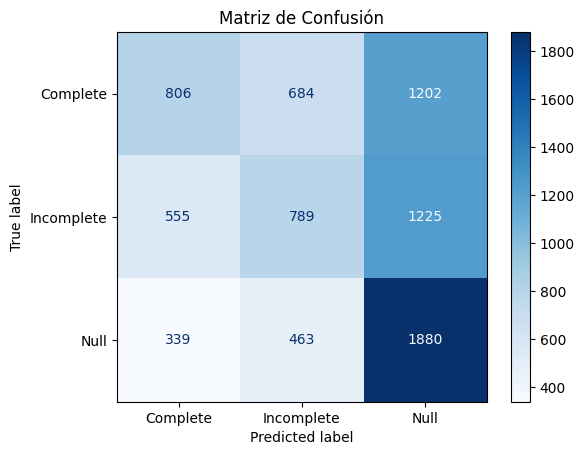

In [ ]:
# Generar la matriz de confusión
cm = confusion_matrix(y_test, y_pred)

# Mostrar la matriz de confusión con nombres de clases
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=encoder.classes_)
disp.plot(cmap="Blues")
plt.title("Matriz de Confusión")
plt.show()

In [ ]:
# Diccionario para mapear números a etiquetas de clase
label_mapping = {0: "Complete", 1: "Incomplete", 2: "Null"}

results = pd.DataFrame({
    "Real": pd.Series(y_test).map(label_mapping),
    "Predicción": pd.Series(y_pred).map(label_mapping)
})

# Filtrar los errores
wrong_predictions = results[results["Real"] != results["Predicción"]]

# Mostrar los primeros casos incorrectos
print("Casos en los que el modelo se equivocó:")
print(wrong_predictions.head())

Casos en los que el modelo se equivocó:
         Real  Predicción
0  Incomplete        Null
1    Complete        Null
2        Null  Incomplete
3  Incomplete    Complete
4    Complete        Null


In [69]:
import joblib
joblib.dump(model, 'nb_model.pkl')

['nb_model.pkl']

Validación del modelo con video de dataset

In [ ]:
# Cargar modelo entrenado
def load_trained_model(model_path):
    return joblib.load(model_path)

import mediapipe as mp
import cv2
import numpy as np

def extract_features_from_video(video_path):
    mp_pose = mp.solutions.pose
    pose = mp_pose.Pose()
    cap = cv2.VideoCapture(video_path)
    landmarks_list = []

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = pose.process(image)

        if results.pose_landmarks:
            landmarks = []
            for landmark in results.pose_landmarks.landmark:
                landmarks.append([landmark.x, landmark.y, landmark.z, landmark.visibility])
            landmarks_list.append(np.array(landmarks).flatten())

    cap.release()
    pose.close()

    return np.array(landmarks_list)


# Función para procesar un video y predecir la etiqueta
def predict_video(video_path, model, encoder):
    landmarks_data = extract_features_from_video(video_path)
    if landmarks_data.shape[0] == 0:
        print(f"No se detectaron landmarks en el video {video_path}")
        return

    predictions = model.predict(landmarks_data)

    # Convertir las predicciones de números a etiquetas
    predicted_labels = encoder.inverse_transform(predictions)

    # Mostrar los resultados
    print(f"Predicción para el video {video_path}: {predicted_labels[-1]}")

# Cargar el modelo KNN entrenado desde un archivo
model_path = 'nb_model.pkl'
model = load_trained_model(model_path)

# Cargar el codificador de etiquetas (LabelEncoder)
encoder = LabelEncoder()
encoder.fit(["Complete", "Incomplete", "Null"])

# Evaluar un video nuevo
video_path = '/content/drive/MyDrive/CDSI/Notebooks/Practica 2/Videos/Mario/Mario_03-Null.MOV'
predict_video(video_path, model, encoder)


Predicción para el video /content/drive/MyDrive/CDSI/Notebooks/Practica 2/Videos/Mario/Mario_03-Null.MOV: Null


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


Validación del modelo con video externo

In [70]:
# Cargar modelo entrenado
def load_trained_model(model_path):
    return joblib.load(model_path)

import mediapipe as mp
import cv2
import numpy as np

def extract_features_from_video(video_path):
    mp_pose = mp.solutions.pose
    pose = mp_pose.Pose()
    cap = cv2.VideoCapture(video_path)
    landmarks_list = []

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = pose.process(image)

        if results.pose_landmarks:
            landmarks = []
            for landmark in results.pose_landmarks.landmark:
                landmarks.append([landmark.x, landmark.y, landmark.z, landmark.visibility])
            landmarks_list.append(np.array(landmarks).flatten())

    cap.release()
    pose.close()

    return np.array(landmarks_list)


# Función para procesar un video y predecir la etiqueta
def predict_video(video_path, model, encoder):
    landmarks_data = extract_features_from_video(video_path)
    if landmarks_data.shape[0] == 0:
        print(f"No se detectaron landmarks en el video {video_path}")
        return

    predictions = model.predict(landmarks_data)

    # Convertir las predicciones de números a etiquetas
    predicted_labels = encoder.inverse_transform(predictions)

    # Mostrar los resultados
    print(f"Predicción para el video {video_path}: {predicted_labels[-1]}")

# Cargar el modelo KNN entrenado desde un archivo
model_path = 'nb_model.pkl'
model = load_trained_model(model_path)

# Cargar el codificador de etiquetas (LabelEncoder)
encoder = LabelEncoder()
encoder.fit(["Complete", "Incomplete", "Null"])

# Evaluar un video nuevo
video_path = '/content/drive/MyDrive/CDSI/Notebooks/Practica 2/persona_01-Incomplete.mov'
predict_video(video_path, model, encoder)


Predicción para el video /content/drive/MyDrive/CDSI/Notebooks/Practica 2/persona_01-Incomplete.mov: Complete


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


En comparación con los modelos anteriores, el rendimiento de Naïve Bayes fue significativamente inferior, con una precisión global de solo 44%. Este modelo tuvo un desempeño particularmente débil en las clases "Complete" e "Incomplete", mientras que mostró un desempeño más adecuado en la clase "Null", probablemente debido a un sesgo hacia la clase más frecuente en el conjunto de datos. Además, el modelo también tuvo problemas de generalización, cometiendo errores similares a los del conjunto de entrenamiento cuando se validó con un video externo.

## **Conclusión**

En esta practica se implementaron técnicas de análisis de landmarks para obtener puntos clave (keypoints) de los videos, con el propósito de realizar una validación automática de la evaluación Fugl-Meyer para la Extremidad Superior (FMA-UE). Esta evaluación es fundamental para medir el deterioro sensoriomotor en personas que han sufrido un accidente cerebrovascular, y se centró en cinco movimientos representativos: flexión de hombro, abducción de hombro, rotación externa de hombro, extensión de codo y extensión de dedos. Los movimientos fueron clasificados en tres categorías: "Complete" (movimiento realizado correctamente), "Incomplete" (movimiento realizado parcialmente con dificultades) y "Null" (movimiento no realizado).

Los modelos de clasificación (Random Forest y KNN) lograron resultados muy buenos en términos de precisión, por otro lado, el modelo de Naïve Bayes, no alcanzó el rendimiento deseado, especialmente en las clases clave, lo que sugiere que no es adecuado para este tipo de tareas sin ajustes importantes.

Los modelos mostraron limitaciones en cuanto a la capacidad de generalización cuando se enfrentan a videos externos, este tipo de problema es común en modelos de aprendizaje automático, donde la generalización a datos de pruebas con características diferentes a las del conjunto de entrenamiento puede verse comprometida. En este caso, las variaciones en el entorno, como la iluminación y la calidad de la grabación, parecen influir negativamente en la capacidad del modelo para realizar predicciones precisas.

En general, la practica ha demostrado que el uso de técnicas de landmarks y modelos de machine learning es viable para la validación automática de la FMA-UE, pero también ha resaltado la necesidad de mejorar la robustez y la capacidad de generalización de los modelos a través de un entrenamiento más diversificado.